#  3D AMRVAC - Reduction

We reduce (or resample) the Magritte model of the 3D AMRVAC snapshot that was created in the [previous example](1_create_AMRVAC_3D.ipynb) using the methods explained in [Ceulemans et al. (2024) in prep]. This is an improvement over the previous implementation of [De Ceuster et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.499.5194D/abstract).

## Setup

Import the required functionalty.

In [1]:
import magrittetorch.tools.radiativetransferutils as rtutils
import magrittetorch.tools.setup as setup
import magrittetorch.tools.mesher as mesher
import torch
from magrittetorch.model.model import Model # Model class
from magrittetorch.model.geometry.geometry import GeometryType # GeometryType enum
from magrittetorch.model.geometry.boundary import BoundaryType # BoundaryType enum
import numpy          as np                   # Data structures
import warnings                               # Hide warnings
warnings.filterwarnings('ignore')             # especially for yt
import yt                                     # 3D plotting
import os

from tqdm           import tqdm               # Progress bars
from astropy        import constants, units   # Unit conversions
from scipy.spatial  import Delaunay, cKDTree  # Finding neighbors
from yt.funcs       import mylog              # To avoid yt output 
mylog.setLevel(40)                            # as error messages

Define a working directory (you will have to change this). We assume here that the scripts of the [previous example](1_create_AMRVAC_3D.ipynb) have already been executed and go back to that working directory.

In [2]:
wdir = "/lhome/thomasc/Magrittetorch-examples/AMRVAC_3D/"

Define file names.

In [3]:
model_file = os.path.join(wdir, 'model_AMRVAC_3D.hdf5')   # Original Magritte model
lamda_file = os.path.join(wdir, 'co.txt'              )   # Line data file
redux_file = os.path.join(wdir, 'model_AMRVAC_3D_red' )   # Reduced Magritte model (no extension!)

Load the original model.

In [4]:
original_model = Model(model_file)
original_model.read()

Reading model from:  /lhome/thomasc/Magrittetorch-examples/AMRVAC_3D/model_AMRVAC_3D.hdf5
Reading Magrittetorch model


Extract the data from the model by casting it into numpy arrays.

In [5]:
position = original_model.geometry.points.position.get_astropy()
velocity = original_model.geometry.points.velocity.get_astropy()
boundary = original_model.geometry.boundary.boundary2point.get()#indices, so need no units
nCO      = original_model.chemistry.species.abundance.get_astropy()[:,0]
nH2      = original_model.chemistry.species.abundance.get_astropy()[:,1]
tmp      = original_model.thermodynamics.temperature.gas.get_astropy()
trb      = original_model.thermodynamics.turbulence.vturb.get_astropy()

Use the (new) built-in remeshing procedure for point clouds

In [6]:
positions_reduced, nb_boundary = mesher.remesh_point_cloud(position, nCO, max_depth=9, threshold= 4e-1, hullorder=4)
boundary_reduced = positions_reduced[:nb_boundary,:]

new interior points:  30635
number boundary points:  1538


Compare the number of points in the original and the reduced mesh.

In [7]:
npoints          = original_model.parameters.npoints.get()
npoints_reduced  = len(positions_reduced)

In [8]:
print('npoints original =', npoints)
print('npoints reduced  =', npoints_reduced)
print('reduction factor =', npoints/npoints_reduced)

npoints original = 304130
npoints reduced  = 32173
reduction factor = 9.452957448792466


Interpolate the data to the reduced mesh. Effectively we find out which points in the original mesh are closes to which point in the reduced mesh and we simpliy map the data between the correpsonding points.

In [9]:
# Find closest points
corresp_points = cKDTree(position).query(positions_reduced)[1]

# Map data
position_reduced = positions_reduced
velocity_reduced = velocity[corresp_points]
nCO_reduced      = nCO     [corresp_points]
nH2_reduced      = nH2     [corresp_points]
tmp_reduced      = tmp     [corresp_points]
trb_reduced      = trb     [corresp_points]

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(position_reduced)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints_reduced)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Convenience arrays
zeros = np.zeros(npoints_reduced)
ones  = np.ones (npoints_reduced)

# map to torch
# The reduction places boundary indices at start of list
boundary_torch = torch.arange((nb_boundary), dtype=torch.int64)
nbs_torch      = torch.tensor(nbs,      dtype=torch.int64)
n_nbs_torch    = torch.tensor(n_nbs,    dtype=torch.int64)

Now all data is read, we can use it to construct a Magrittetorch model.

<div class="alert alert-warning">

Warning

Including all radiative transitions can be computationally expensive (both in time and memory cost) for self-consistent NLTE radiative transfer. For LTE radiative transfer, this is not the case, altough if one wants to image a specific line, that line must be in the list of considered transitions. For these examples, we include the first 10 radiative transitions of CO (J=1-0 to J=10-9). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.

</div>

In [10]:
reduced_model = Model (f'{redux_file}.hdf5')                     # Create model object
reduced_model.geometry.geometryType.set(GeometryType.General3D) # This is a 3D model
reduced_model.geometry.boundary.boundaryType.set(BoundaryType.AxisAlignedCube) # With a cubic boundary

# In order to make unit conversions trivial, we use astropy quantities as input
reduced_model.geometry.points.position.set_astropy(position_reduced) # Set point positions
reduced_model.geometry.points.velocity.set_astropy(velocity_reduced) # Set point velocities
reduced_model.chemistry.species.abundance.set_astropy(np.stack([nCO_reduced, nH2_reduced, np.zeros(npoints_reduced)/units.m**3], axis=1))# Set species number densities
reduced_model.chemistry.species.symbol.set(np.array(['CO', 'H2', 'e-'], dtype='S')) #Set species symbols; should correspond to the LAMDA file format
#Note: the dtype='S' is necessary to correctly save and read the species symbols to/from the hdf5 file

reduced_model.thermodynamics.temperature.gas.set_astropy(tmp_reduced) # Set gas temperature
reduced_model.thermodynamics.turbulence.vturb.set_astropy(trb_reduced) # Set turbulence velocity

# Set the neighbors
reduced_model.geometry.points.neighbors.set(nbs_torch) # Set neighbors
reduced_model.geometry.points.n_neighbors.set(n_nbs_torch) # Set number of neighbors
reduced_model.geometry.boundary.boundary2point.set(boundary_torch) # Set which points are boundary points

reduced_model = setup.set_boundary_condition_CMB  (reduced_model) # Set CMB as boundary condition
reduced_model = setup.set_uniform_rays            (reduced_model, 12) # Number of rays for NLTE raytracing; has be of the form 12*2**n

#As this example does not do NLTE, we might as well only consider the first 10 transitions of CO
reduced_model = setup.set_linedata_from_LAMDA_file(reduced_model, lamda_file, {'considered transitions': [i for i in range(10)]})
# reduced_model = setup.set_linedata_from_LAMDA_file(reduced_model, lamda_file)   # Consider all transitions
reduced_model = setup.set_quadrature              (reduced_model, 7) # Set number of frequency quadrature points for NLTE radiative transfer

reduced_model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing model to:  /lhome/thomasc/Magrittetorch-examples/AMRVAC_3D/model_AMRVAC_3D_red.hdf5


## Plot model

Load the data in a `yt` unstructured mesh.

In [11]:
ds = yt.load_unstructured_mesh(
         connectivity = delaunay.simplices.astype(np.int64),
         coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m
         node_data    = {('connect1', 'n'): nCO_reduced[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis.


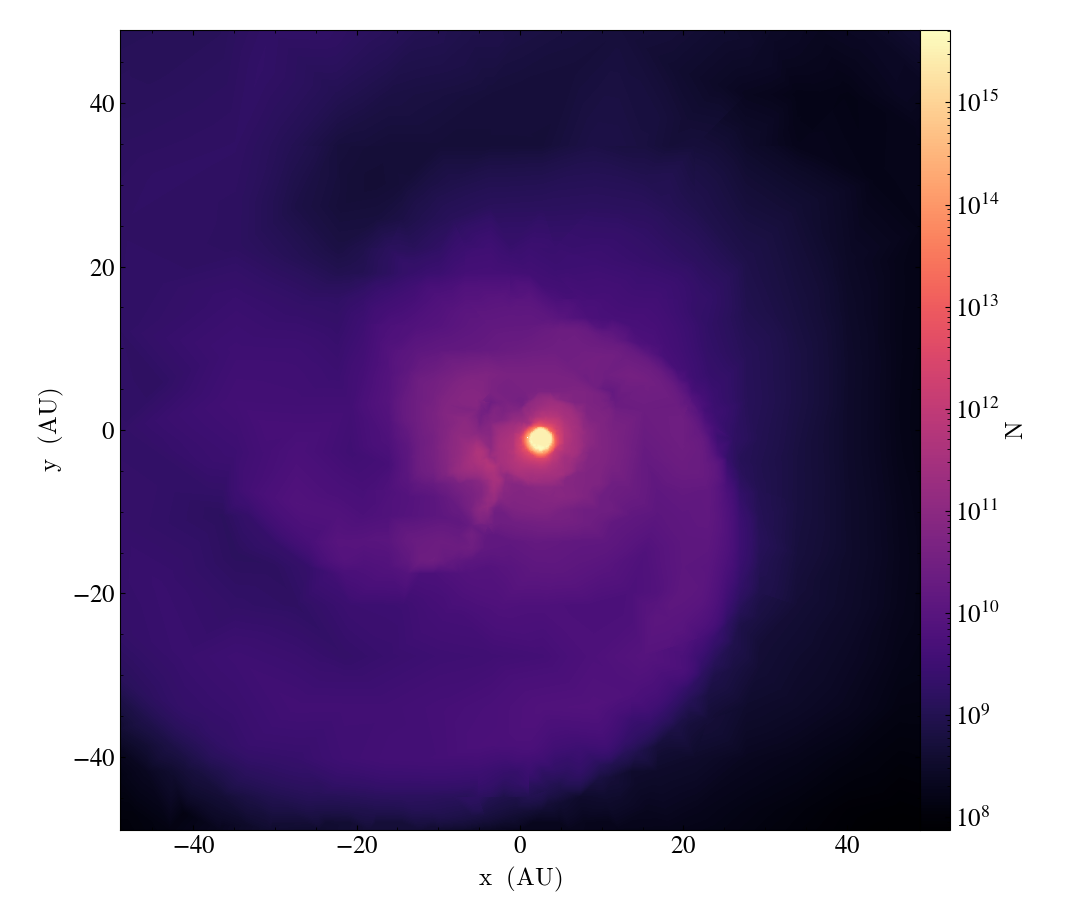

In [12]:
sl = yt.SlicePlot (ds, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.1)

Show mesh on the plot.


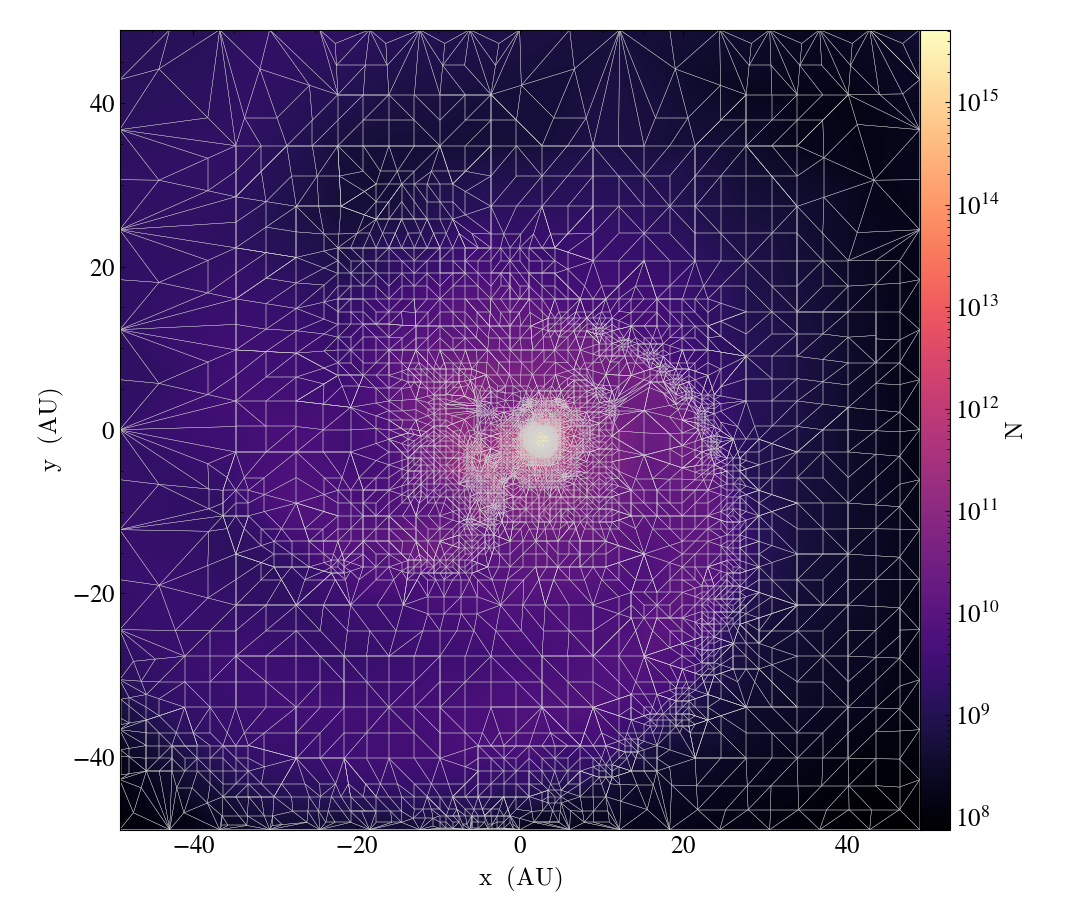

In [13]:
sl = yt.SlicePlot      (ds, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.1)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})